# Detect disturbed tress

## Packages and Data

In [33]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from utils.preprocessing import Preprocessing
from utils.visualization_utils.visualization_time_series import plot_timeseries_oneid
from utils.correlation_analysis import CorrelationAnalysis

from src.preprocessing.preprocessing_steps.detect_disturbed_trees import DetectDisturbedTrees

from utils.constants import spectral_bands, indices
bands_and_indices = spectral_bands + indices

In [ ]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../data/Trainings_Datensatz.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

df = Preprocessing.interpolate_b4(df, method="linear")

calculateindices = CalculateIndices()
df = calculateindices.add_all_indices(df)

disturbed_detector = DetectDisturbedTrees()

## Idea and Approach 

*How to identifying Sick Trees (Not Labeled as “Disturbed”)?*

**Identify features that can indicate tree disease**

- **Normalization**  
  Each spectral band and index was normalized separately.  
  - This equalized value ranges across bands and improved correlation with labels.  
  - Though not a standard ML approach, it gave better results in this case.

- **Yearly Aggregation**  
  Data was averaged per year before feature calculation.  
  - This reduced seasonal noise and highlighted long-term trends.

- **Feature Calculation (per tree ID)**  
  From yearly means, two key features were identified:  
  - **Slope** of yearly means
  - **Standard deviation** of yearly means
  - The difference between first and last year was not useful.

- **Feature Analysis**  
  - Correlations with the label (`is_disturbed`) were calculated.  
  - IDs with high feature values (e.g., large `b11_slope`) were plotted to verify if they indicated disease.  
  - This helped confirm the most informative features.


1. Normalize columns so that those with higher ranges do not have a greater influence
2. Group by year and compute the mean of each index column
3. Compute the standard deviation of the yearly values
4. Join column "is_disturbed" to the resulting df

In [ ]:
df_scaled = disturbed_detector.scale_data(df)
# normalization grouped by species because different species can have different ranges

df_yearly = disturbed_detector.get_yearly_data(df_scaled)

df_std = disturbed_detector.get_std(df_yearly)
df_slope = disturbed_detector.get_slope(df_yearly)

df_std_slope = df_std.merge(df_slope, on="id", how="left")
df_std_slope = disturbed_detector.get_label(df, df_std_slope)
df_std_slope

## Correlation between features and disturbance

In [ ]:
corr_analyser = CorrelationAnalysis(df_std_slope)
correlations = corr_analyser.get_correlations_with_target("is_disturbed")
correlations

,feature,correlation,p_value
28,b11_slope,0.531285,0.000000e+00
23,b5_slope,0.528492,0.000000e+00
8,b11_stdv,0.517996,0.000000e+00
11,gndvi_stdv,0.514982,0.000000e+00
3,b5_stdv,0.501880,0.000000e+00
20,b2_slope,0.492893,0.000000e+00
43,b5_diff,0.488226,0.000000e+00
15,ipvi_stdv,0.487777,0.000000e+00
10,ndvi_stdv,0.487777,0.000000e+00
14,savi_stdv,0.486328,0.000000e+00


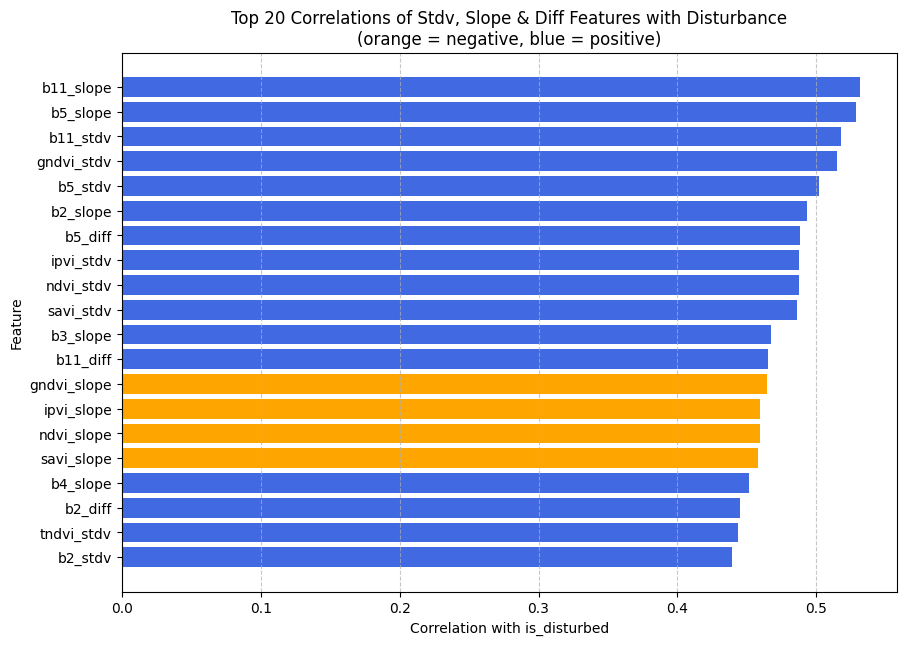

In [ ]:
corr_analyser.plot_correlations_with_target(correlations, top_n=20)

## Analysis stdv, slope & diff of indices 

In [47]:
col = "b11"
slope_or_stdv = "slope"
stdv_slope_diff_df[~stdv_slope_diff_df["is_disturbed"]].sort_values(
    f"{col}_{slope_or_stdv}", ascending=False
)

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,ndvi_diff,gndvi_diff,wdvi_diff,tndvi_diff,savi_diff,ipvi_diff,mcari_diff,reip_diff,masvi2_diff,dvi_diff
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.324991,-0.128959,-0.077927,-0.277194,-0.324969,-0.324991,-0.001542,0.000047,0.001743,-0.115229
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,-0.214669,-0.156624,0.041912,-0.147256,-0.214620,-0.214669,-0.001181,-0.001382,-0.007265,0.019520
26201,26202,0.013934,0.016201,0.027229,0.025218,0.014909,0.014042,0.016933,0.016095,0.109507,...,-0.207304,-0.149813,0.032107,-0.139968,-0.207223,-0.207304,-0.001641,-0.001918,-0.008741,0.013195
6176,6177,0.013941,0.016781,0.026801,0.025058,0.017302,0.016253,0.019201,0.018143,0.107465,...,-0.218062,-0.165039,0.039738,-0.147240,-0.218001,-0.218062,-0.001046,-0.001848,-0.007410,0.020800
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,-0.236334,-0.173603,0.037778,-0.160397,-0.236278,-0.236334,-0.002015,-0.001179,-0.007132,0.015360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19972,19973,0.004048,0.009329,0.012597,0.016100,0.031562,0.034840,0.043284,0.037841,0.032613,...,0.056347,0.039467,0.011180,0.047286,0.056353,0.056347,-0.000462,0.001241,-0.007789,0.016942
22319,22320,0.012512,0.014623,0.011250,0.016384,0.033185,0.037978,0.041252,0.037826,0.042537,...,0.011598,0.025977,-0.063246,0.007815,0.011592,0.011598,-0.002582,0.000290,0.000898,-0.070560
14016,14017,0.031947,0.048587,0.061931,0.059145,0.054104,0.051903,0.054228,0.049897,0.048233,...,0.069388,0.067401,-0.083020,0.064307,0.069452,0.069388,0.001557,-0.000259,0.000199,-0.000491
17513,17514,0.121576,0.119378,0.118368,0.117796,0.107294,0.103265,0.104693,0.099919,0.103603,...,0.056329,0.070051,-0.152263,0.048736,0.056387,0.056329,0.000569,-0.000032,0.000060,0.012431


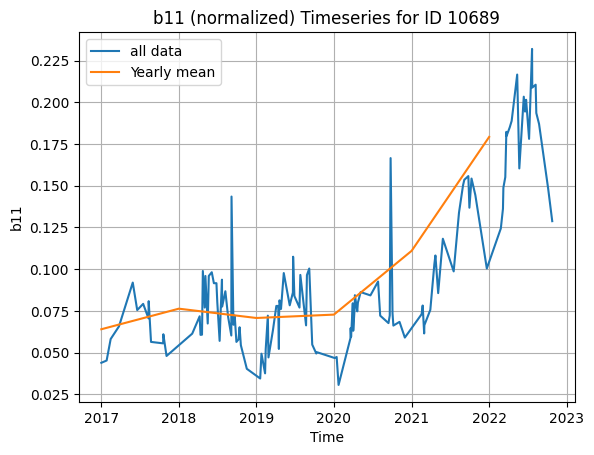

In [ ]:
plot_timeseries_oneid(df_scaled, 10689, "b11", df_yearly) 

## Model to detect mislabeled trees

### Build training data from data with presumably correctly labeled data

In [49]:
disturbed_df = stdv_slope_diff_df[stdv_slope_diff_df["is_disturbed"]].copy()
healthy_df = stdv_slope_diff_df[~stdv_slope_diff_df["is_disturbed"]].copy()

In [50]:
top_features = ["b11_slope", "b5_slope", "b11_stdv", "gndvi_stdv"]
healthy_df["combi_top_features"] = healthy_df[top_features].mean(axis=1)
healthy_df.sort_values(by="combi_top_features")

,id,b2_stdv,b3_stdv,b4_stdv,b5_stdv,b6_stdv,b7_stdv,b8_stdv,b8a_stdv,b11_stdv,...,gndvi_diff,wdvi_diff,tndvi_diff,savi_diff,ipvi_diff,mcari_diff,reip_diff,masvi2_diff,dvi_diff,combi_top_features
12043,12044,0.003088,0.003261,0.007149,0.005418,0.006134,0.006345,0.007030,0.005714,0.003331,...,-0.000299,-0.015612,0.019195,0.021375,0.021360,0.000574,-0.000118,1.117116e-04,-0.003839,0.000652
10951,10952,0.022716,0.022592,0.024803,0.019423,0.016529,0.015527,0.019662,0.016593,0.011202,...,0.004491,-0.037935,-0.003433,-0.003140,-0.003136,0.001132,0.001762,3.325936e-05,-0.002958,0.000733
15155,15156,0.000397,0.001539,0.000668,0.001931,0.006208,0.007066,0.006467,0.007664,0.001977,...,0.005851,-0.008132,-0.005616,-0.008510,-0.008324,-0.000769,0.000368,4.485918e-05,-0.007719,0.000735
23144,23145,0.000601,0.000953,0.000389,0.000911,0.002480,0.002882,0.002695,0.003387,0.000899,...,0.003262,0.000876,0.002389,0.003727,0.003649,-0.000146,-0.000011,-1.259024e-07,0.001067,0.000760
17446,17447,0.002315,0.002662,0.002019,0.001949,0.003682,0.003114,0.003856,0.003112,0.000826,...,-0.004276,-0.007790,-0.012357,-0.012898,-0.012886,-0.000188,0.000266,6.482195e-05,-0.006998,0.000821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,24991,0.014754,0.017541,0.028682,0.025342,0.017278,0.016097,0.018597,0.017729,0.106960,...,-0.176000,0.038184,-0.157136,-0.232065,-0.232122,-0.002026,-0.000901,-7.114118e-03,0.016530,0.062107
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.128959,-0.077927,-0.277194,-0.324969,-0.324991,-0.001542,0.000047,1.742990e-03,-0.115229,0.062299
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,-0.173603,0.037778,-0.160397,-0.236278,-0.236334,-0.002015,-0.001179,-7.131621e-03,0.015360,0.062560
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,-0.156624,0.041912,-0.147256,-0.214620,-0.214669,-0.001181,-0.001382,-7.264696e-03,0.019520,0.062853


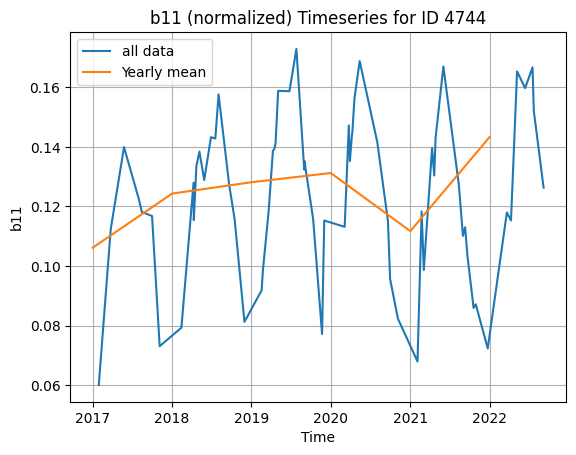

In [51]:
plot_timeseries_oneid(4744, col)

- Idea: Healthy df with 10,000 data points that are almost certainly not disturbed
- the four top features must have a low value

- Testing of random samples showed that the first 20,000 rows of healthy_df should not be disturbed trees.

In [52]:
healthy_df_sub = (
    healthy_df.sort_values(by="combi_top_features")
    .head(20000)
    .sample(n=10000, random_state=42)
)

train_df = (
    pd.concat([disturbed_df, healthy_df_sub])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print("Disturbed:", len(disturbed_df))
print("Healthy (balanced):", len(healthy_df_sub))
print("Training set total:", len(train_df))

Disturbed: 3630
Healthy (balanced): 10000
Training set total: 13630
